In [118]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
from collections import defaultdict, namedtuple, Counter
from itertools import combinations
import numpy as np
import scipy.stats as stats
import sys
from os import listdir
import json
import argparse
import random
import scipy.sparse as sparse
import csv
import cvxpy as cp
import statsmodels.api as sm

In [40]:
dataset = '../permutation_tests/spark.2'
chroms = np.load('%s.chroms.npy' % dataset)
intervals = np.load('%s.intervals.npy' % dataset)
z = np.load('%s.npy' % dataset)[:, 2]

with open('%s.sibpairs.json' % dataset, 'r') as f:
    sibpairs = json.load(f)
print(len(sibpairs))
is_mat_match = np.load('%s.is_mat_match.npy' % dataset)
is_pat_match = np.load('%s.is_pat_match.npy' % dataset)

start_pos, end_pos = 72897465, 73361654


1472


In [41]:
peak_starts = np.where((z[1:]<=0.05) & (z[:-1]>0.05))[0]+1
peak_ends = np.where((z[1:]>0.05) & (z[:-1]<=0.05))[0]+1

for peak_start, peak_end in zip(peak_starts, peak_ends):
    print(chroms[peak_start], intervals[0, peak_start], chroms[peak_end], intervals[0, peak_end])
    print(z[peak_start:peak_end])

8 72897465 8 72901633
[0.05]
8 72902849 8 72908839
[0.05]
8 72920056 8 72938577
[0.04 0.05 0.05 0.05]
8 72939640 8 73361654
[0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.05 0.04 0.05 0.04 0.04 0.04 0.04
 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04
 0.04 0.04 0.04 0.05 0.04 0.05 0.05]
17 6426749 17 6666852
[0.04 0.05 0.04 0.05 0.05 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04
 0.04 0.04 0.04 0.05 0.04 0.04 0.04 0.04 0.04 0.04 0.05 0.05 0.05 0.05]
17 6669048 17 6669505
[0.05]
17 6670773 17 6965244
[0.05 0.05 0.05 0.04 0.05 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04
 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.04 0.03 0.04 0.04 0.04 0.04 0.03 0.03 0.03 0.04 0.04
 0.04 0.04 0.04 0.05 0.05 0.04 0.04 0.05]
17 6977401 17 6978790
[0.05]


In [42]:
start_index, end_index = np.where(intervals[0, :]==start_pos)[0][0], np.where(intervals[0, :]==end_pos)[0][0]
print(z[start_index:end_index])

[0.05 0.06 0.05 0.06 0.04 0.05 0.05 0.05 0.06 0.04 0.04 0.04 0.04 0.04
 0.04 0.04 0.05 0.04 0.05 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04
 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.05 0.04
 0.05 0.05]


In [133]:
# pick majority for each sibpair
mat_ibd = is_mat_match[:, start_index:end_index].dot((intervals[1, start_index:end_index]-intervals[0, start_index:end_index]))
print(np.sum(mat_ibd==0)) # if any sibpair is 0, we need to discard them
mat_ibd = mat_ibd > 0

pat_ibd = is_pat_match[:, start_index:end_index].dot((intervals[1, start_index:end_index]-intervals[0, start_index:end_index]))
print(np.sum(pat_ibd==0)) # if any sibpair is 0, we need to discard them
pat_ibd = pat_ibd > 0

ibd = np.hstack((mat_ibd, pat_ibd))
print(ibd.shape)



0
0
(2944,)


In [134]:
sample_to_phen = dict()
with open('../../PhasingFamilies/phenotypes/v5/scq.csv', 'r') as f:
    reader = csv.reader(f)
    for pieces in reader:
        phen = [-1 if (x not in {'1', '0'}) else int(x) for x in pieces[11:51]]
        sample_to_phen[pieces[0]] = phen
        

In [135]:
print(list(sample_to_phen.items())[4])

('SP0000026', [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, -1, 0, 1, 1, 1, 0, 1, 1, 1])


In [136]:
print(sibpairs[0])

['SF0000027.SP0000027.SP0000034', 'SP0000027', 'SP0000034', 'SP0000051', 'SP0000241', '../PhasingFamilies/phased_spark_wes1_array_quads_del', 2, 2, True, True, True, True]


In [137]:
phen_match = []
for sibpair in sibpairs:
    if sibpair[1] in sample_to_phen and sibpair[2] in sample_to_phen:
        phen1 = sample_to_phen[sibpair[1]]
        phen2 = sample_to_phen[sibpair[2]]
        phen_match.append([-1 if (x==-1 or y==-1) else int(x==y) for x, y in zip(phen1, phen2)])
    else:
        phen_match.append([-1]*40)
phen_match = np.array(phen_match)

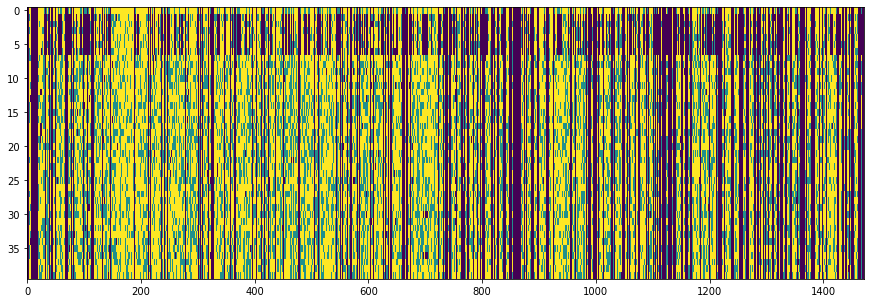

In [138]:
plt.figure(figsize=(15, 5))
plt.imshow(phen_match.T, aspect='auto')
plt.show()

In [139]:
print(np.sum(np.all(phen_match==-1, axis=1)))

427


In [140]:
X = np.hstack((ibd[:, np.newaxis], np.ones((ibd.shape[0], 1))))
print(X.shape)

(2944, 2)


In [141]:
indices_x, indices_y = np.where(phen_match!=-1)

In [146]:
print(np.vstack((phen_match[indices, phen_index], phen_match[indices, phen_index])).shape)

(2, 1042)


In [147]:
for phen_index in range(40):
    indices = phen_match[:, phen_index]!=-1
    model = sm.Logit(np.hstack((phen_match[indices, phen_index], phen_match[indices, phen_index])), 
                     X[indices.tolist()+indices.tolist(), :])
    result = model.fit(disp=False)
    if result.pvalues[0] < 0.05:
        print(phen_index+1, result.pvalues[0])

15 0.010615379184064523
26 0.01747741872242309
31 0.041415722334935276


In [153]:
W = np.zeros((phen_match.shape[0], 1 + 2*phen_match.shape[1]))
for phen_index in range(40):
    W[phen_match[:, phen_index]==0, 2*phen_index] = 1
    W[phen_match[:, phen_index]==1, 2*phen_index + 1] = 1
W[:, -1] = 1

model = sm.Logit(ibd[:int(ibd.shape[0]/2)], W[:, :-1])
result = model.fit()
print(result.summary())

         Current function value: 0.647617
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1472
Model:                          Logit   Df Residuals:                     1392
Method:                           MLE   Df Model:                           79
Date:                Thu, 23 Sep 2021   Pseudo R-squ.:                 0.05989
Time:                        21:45:31   Log-Likelihood:                -953.29
converged:                      False   LL-Null:                       -1014.0
Covariance Type:            nonrobust   LLR p-value:                  0.001525
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2030      1.461      0.139      0.890      -2.661       3.067
x2             0.2505      1.471      0.170      0.865      -2.63

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [131]:
print(ibd)

[ True  True  True ... False  True False]
